# Relating Age to Name - Modified

This notebook is inspired by [Nate Silver's](https://twitter.com/FiveThirtyEight) recent article on [How to Tell Someone's Age When All you Know is Her Name](http://fivethirtyeight.com/features/how-to-tell-someones-age-when-all-you-know-is-her-name/). It allows one to (almost) replicate the analysis done in the article, and provides more extensive features. I have done similar work using R, and you can find it [here](https://github.com/ramnathv/agebyname).

## Data

We will uses four primary datasets.

1. [Babynames](http://www.ssa.gov/oact/babynames/names.zip)
2. [Babynames by State](http://www.ssa.gov/oact/babynames/state/namesbystate.zip)
3. [Cohort Life Tables](http://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_7.html)
4. [Census Live Births Data](http://www.census.gov/statab/hist/02HS0013.xls)

We will download each of these datasets and process them to get them analysis ready.

In [1]:
%matplotlib inline
import re
import urllib
from zipfile import ZipFile
from os import path
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *

### Baby Names

The first dataset we will be downloading is the [bnames](http://www.ssa.gov/oact/babynames/names.zip) dataset provided by SSA

In [216]:
DIR = 'C:\\Users\Elaine\\Documents\\GitHub\\agebyname_py\\'

In [217]:
#urllib.urlretrieve("http://www.ssa.gov/oact/babynames/names.zip", "names.zip")
zf = ZipFile(DIR+"names.zip")
def read_names(f):
  data = pd.read_csv(zf.open(f), header = None, names = ['name', 'sex', 'n'])
  data['year'] = int(re.findall(r'\d+', f)[0])
  return data
  
bnames = pd.concat([read_names(f) for f in zf.namelist() if f.endswith('.txt')])
names_ =  set(bnames.name)
bnames.head()


,name,sex,n,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


### Baby Names by State

The second dataset we will be downloading is the [bnames_by_state](http://www.ssa.gov/oact/babynames/namesbystate.zip) dataset, also provided by SSA

In [218]:
#urllib.urlretrieve("http://www.ssa.gov/oact/babynames/state/namesbystate.zip", "namesbystate.zip")
#zf = ZipFile("namesbystate.zip")
#def read_names2(f):
#  return pd.read_csv(zf.open(f), header = None, names = ['state', 'sex', 'year', 'name', 'n'])
  
#bnames_by_state = pd.concat([read_names2(f) for f in zf.namelist() if f.endswith('.TXT')])
#bnames_by_state.name.head()

### Cohort Life Tables

The next dataset is actuarial [cohort life tables](http://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_7.html) provided by SSA. I was unable to figure out how to scrape this data using `BeautifulSoup`. So I used the R package `XML` to scrape these lifetables and saved it to [lifetables.csv](lifetables.csv). If you are interested in the R code, you can find it [here](https://github.com/ramnathv/agebyname/blob/master/rawdata/lifetables.R).

In [220]:
lifetables = pd.read_csv(DIR+'lifetables.csv')
lifetables.head()

,x,qx,lx,dx,Lx,Tx,ex,sex,year
0,0,0.14596,100000,14596,90026,5151511,51.52,M,1900
1,1,0.03282,85404,2803,84003,5061484,59.26,M,1900
2,2,0.01634,82601,1350,81926,4977482,60.26,M,1900
3,3,0.01052,81251,855,80824,4895556,60.25,M,1900
4,4,0.00875,80397,703,80045,4814732,59.89,M,1900


You can read the documentation for the lifetables to understand the various parameters. The key column of interest to us is `lx`, which provides the number of people born in the year `year` who live upto the age `x`. Since we are in the year 2014, we are only interested in a subset of the data. 

In [221]:
lifetables_2014 = lifetables[lifetables['year'] + lifetables['x'] == 2014]
lifetables_2014.head()

,x,qx,lx,dx,Lx,Tx,ex,sex,year
114,114,0.76365,0,0,0,0,0.79,M,1900
234,114,0.75783,0,0,0,0,0.80,F,1900
344,104,0.46882,25,12,19,38,1.54,M,1910
464,104,0.42317,191,81,150,328,1.72,F,1910
574,94,0.26858,3122,838,2703,8656,2.77,M,1920


The cohort life tables are provided only for every decade. Since we need the data by year, we will use spline interpolation to fill out the gaps.

In [222]:
def process(d, kind = 'slinear'):
  f = interp1d(d.year, d.lx, kind)
  year = np.arange(1900, 2011)
  lx = f(year)
  return pd.DataFrame({"year": year, "lx": lx, "sex": d.sex.iloc[1]})

lifetable_2014 = lifetables_2014.\
  groupby('sex', as_index = False).\
  apply(process)
lifetable_2014.head()

lx sex  year
0 0   0.0   F  1900
  1  19.1   F  1901
  2  38.2   F  1902
  3  57.3   F  1903
  4  76.4   F  1904

### Census Live Births Data

Finally, we need [live births data](http://www.census.gov/statab/hist/02HS0013.xls) from the census to extrapolate the birth data to account for the correct that not all births were recorded by SSA till around 1930, since it wasn't mandatory.

In [224]:
#urllib.urlretrieve("http://www.census.gov/statab/hist/02HS0013.xls", "02HS0013.xls")
dat = pd.read_excel(DIR+'02HS0013.xls', sheetname = 'HS-13', skiprows = range(14))
tot_births = dat.ix[9:101,:2].reset_index(drop = True)
tot_births.columns = ['year', 'births']
tot_births = tot_births.convert_objects(convert_numeric = True)
tot_births.head()

,year,births
0,1909,2718
1,1910,2777
2,1911,2809
3,1912,2840
4,1913,2869


We will now merge this data with the `bnames` aggregated by `year` to compute a set of correction factors, which will be used to scale the number of births. I have taken a very naive approach to do this, and there might be better ways to accomplish the same.

In [225]:
cor_factors = bnames.groupby('year', as_index = False).sum().merge(tot_births)
#print cor_factors
cor_factors['cor'] = cor_factors['births']*1000/cor_factors['n']
#print cor_factors
cor_factors = cor_factors[['year', 'cor']]
cor_factors.head()

,year,cor
0,1909,5.316621
1,1910,4.701051
2,1911,4.359994
3,1912,2.874354
4,1913,2.523141


We expand the correction factors data for the years 2002 to 2014 using the correction factor for the year 2001.

In [226]:
cor_new = pd.DataFrame({
  'year': range(2002, 2014),
  'cor': cor_factors.cor.iloc[-1]
})
cor_factors = pd.concat([cor_factors, cor_new])[['year', 'cor']]
cor_factors.head()

,year,cor
0,1909,5.316621
1,1910,4.701051
2,1911,4.359994
3,1912,2.874354
4,1913,2.523141


## Analysis

Now that we have all the required data, we need a few helper functions to help us with our analysis. The first function we will write is `get_data`, which takes `name`, `sex` and `state` and returns a data frame with the distribution of number of births and number of people alive by year.

In [11]:
"""def get_data(name, sex, state = None):
  if state is None:
    dat = bnames
  else:
    dat = bnames_by_state[(bnames_by_state["state"] == state)]
  data = dat[(dat['name'] == name) & (dat['sex'] == sex)].\
    merge(cor_factors).\
    merge(lifetable_2014)
  data['n_cor'] = data['n']*data['cor']
  data['n_alive'] = data['lx']/(10**5)*data['n_cor']
  return data
get_data('Violet', 'F').head()"""

'def get_data(name, sex, state = None):\n  if state is None:\n    dat = bnames\n  else:\n    dat = bnames_by_state[(bnames_by_state["state"] == state)]\n  data = dat[(dat[\'name\'] == name) & (dat[\'sex\'] == sex)].    merge(cor_factors).    merge(lifetable_2014)\n  data[\'n_cor\'] = data[\'n\']*data[\'cor\']\n  data[\'n_alive\'] = data[\'lx\']/(10**5)*data[\'n_cor\']\n  return data\nget_data(\'Violet\', \'F\').head()'

In [227]:
bname= bnames.set_index(['name'], inplace=True)

In [228]:
def get_data(name):
    dat = bnames
    dat = dat.loc[name]
    if type(dat) == pd.Series:
        m = pd.DataFrame(bnames.loc[name]).transpose()
    else:
        m = dat
    data =   m.\
            merge(cor_factors).\
            merge(lifetable_2014)
    data['n_cor'] = data['n']*data['cor']
    data['n_alive'] = data['lx']/(10**5)*data['n_cor']
    return data
get_data('Zebra')  

,sex,n,year,cor,lx,n_cor,n_alive
0,F,5,1957,1.023803,90165.1,5.119016,4.615566


In [14]:
"""def get_data(name, state = None):
  if state is None:
    dat = bnames
  else:
    dat = bnames_by_state[(bnames_by_state["state"] == state)]
  data = dat.loc[name].\
    merge(cor_factors).\
    merge(lifetable_2014)
  data['n_cor'] = data['n']*data['cor']
  data['n_alive'] = data['lx']/(10**5)*data['n_cor']
  data['fraction'] = (data['n_alive']/data['n_alive'].sum())*100 #tell us the fraction of people named "name" who are 'n' years old.
  return data
get_data('Violet').head()"""

'def get_data(name, state = None):\n  if state is None:\n    dat = bnames\n  else:\n    dat = bnames_by_state[(bnames_by_state["state"] == state)]\n  data = dat.loc[name].    merge(cor_factors).    merge(lifetable_2014)\n  data[\'n_cor\'] = data[\'n\']*data[\'cor\']\n  data[\'n_alive\'] = data[\'lx\']/(10**5)*data[\'n_cor\']\n  data[\'fraction\'] = (data[\'n_alive\']/data[\'n_alive\'].sum())*100 #tell us the fraction of people named "name" who are \'n\' years old.\n  return data\nget_data(\'Violet\').head()'

In [37]:
########################################
####Define brackets to make analysis ####
#########################################

from collections import defaultdict
import pickle

def age_brackets(name, gender=None):
    
    if len(name) > 1:
        name = name.split()[0].lower().title()
    else:
        name = name.lower().title()
    if gender == 'male':
        gender = 'M'
    else:
        gender = 'F'

    dic = defaultdict(list)
    s=0
    s2=0
    s3=0
    s4=0
    f=0 
    f2=0
    f3=0
    f4=0
    s1=0
    f1=0
    s5=0
    f5=0
    
    m = get_data(name).as_matrix()
    if len(m) != 0:
        for t in m:
            if t[2]>=1996:
                s = s+t[1]
                f = f + t[6]
                dic['B1'] = s,f
            elif t[2] >= 1990 and t[3]<=1995:
                s1 = s1+t[1]
                f1 = f1 + t[6]
                dic['B2'] = s1,f1
            elif t[2] >= 1980 and t[3]<=1989:
                s2 = s2+t[1]
                f2 = f2 + t[6]
                dic['B3'] = s2,f2
            elif t[2] >= 1970 and t[3]<=1979:
                s3 = s3+t[1]
                f3 = f3 + t[6]
                dic['B4'] = s3,f3
            elif t[2] >= 1960 and t[2] <= 1969:
                s4 = s4+t[1]
                f4 = f4 + t[6]
                dic['B5'] = s4,f4
            elif t[2] <= 1961:
                s5 = s5+t[1]
                f5 = f5 + t[6]
                dic['B6'] = s5,f5
    
        d = pd.DataFrame(dic.values(),dic.keys(), columns=['n','n_alive'])
        d['fraction']= (d['n_alive']/d['n_alive'].sum())*100

        pickle.dump(d, open( 'C:/Users/Elaine/Documents/GitHub/agebyname_py/name1/' + name +'.pkl', 'wb'))

In [16]:
######################
### Getting tweets ###
######################

tweets = pickle.load(open('C:\\Users\\Elaine\\Documents\\GitHub\\tweets.pkl', 'rb'))
print len(tweets)

992633


In [23]:
## Method gets the first name of each tweet user ###

name = []

def first_name(name):
    if len(name) > 1:
        name = name.split()[0].lower().title()
    else:
        name = name.lower().title()
    #print name
    return name
    

In [24]:
for t in tweets:
        name.append(first_name(t['real_name']))            
print len(set(name))

178814


In [ ]:
### Save on disk each name and its brackets for age ###

i=0
gone = set()

for t in tweets:
    n=first_name(t['real_name'])
    print n        
    if n in set(names_) and n not in gone:
        gone.add(n)
        #print n
        age_brackets(t['real_name'])
        i = i+1
        #print i

Brentt
Steven
Compra
Tyler
Mariano
Dolphin
Stephanie
Joy
Jae
Ashleyy
Cat
Michael
Alexis
Sex
Kassidy
Damaged,
Kelsey�??Wasnesky
Erin
Wi�?�?
I
Ev
Jay
Jas.
Ayana
Patricio
Lewisville
�?�
Ramona
Mc
Chris
Masterscraft
Broly
Masterscraft
Masterscraft
Masterscraft
Tanchelle
James
Kristi
Mario
Aaron
7Th
Jenn
Austin
Hillaryyyy
Conception
Diana
Morris
Sex
Richard
Lisa
Justin
Alexxa.
Juicy
Elan
Clay
://Mz.Roe
Alex
????
Richard
Elchati
Whiteh03
Ganjababemandy?
Soc
Elan
Livingcannabis
C
Red
Janette
Ken
Dennis
William
Jonathan
Nicole
The
Arianna
William
V.V.
Zisman.
Zebra
David
Zebra
Zebra
Travis
Aleph-Null
Frank
Kel'C
Gail
Lewisville
Lewisville
Elan
Kristianized
Ataca
Vincent
Lucinda
Jennifer
Cassy
Jennifer
Mistymountain
Simple_Minded
Brent
Sirhellsing420
Justme&&You(:
Alicia
Oliver
Grace
?Lukastro�
Prosfores-Deals.Gr
Santiago
Russell
Karmah
Ted
Lewisville
Eugene
Lee
Canuckclicks
Darrian
Jared
?T-Deckah!
�?�Eat
Danny
Anthony
Fuzzy
Pappa
Ejo
Rodgy
Ig:
Storm
Mgt
Serch
Pandora
Drewby
Markelaskeeper
*Ca

In [229]:
age_brackets('Reynell')


In [46]:
# Parse dates from tweets 

import matplotlib.pyplot as plt
import datetime

%pylab inline
def parse_date(datestring):
    """ Input, e.g., 10/1/2012
    Output, e.g., 2012-10"""
    parts = datestring.split()
    if len(parts) > 1:
        datestring = parts[0]
        parts = datestring.split('/')
        if len(parts) == 3:
            s = (parts[2] if len(parts[2]) == 4 else '20' + parts[2]) + \
            '-' + (parts[0] if len(parts[0]) == 2 else '0'+parts[0])
            return datetime.datetime.strptime(s, "%Y-%m").date()
    return None

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [207]:
# Select sentiment of tweets to plot graph

positive_tweets = [t for t in tweets if t['class']=='0']

In [208]:
import glob, os
# reads each file for getting each bracket and summing up the values of the fraction of percentage of a person with 'n' years old 
# who is still alive

def data_gender(b,m,y,pos):
   
    DIR = 'C:/Users/Elaine/Documents/GitHub/agebyname_py/names_/'
    os.chdir("C:/Users/Elaine/Documents/GitHub/agebyname_py/names_/")
    gone = []
    summ = 0
    aa1 = 0
    count = 0
    
    for p in pos:
        if parse_date(p['posted_time']).month == m and parse_date(p['posted_time']).year == y:
            name = first_name(p['real_name'])
            if p['gender'] != 'unknown' and name not in gone:  
                gone.append(name)
                file_ = pickle.load(open(DIR+name+'.pkl'))
                aa = file_.to_dict()

                aa1 += aa['fraction'][b]
                count +=1       
    return aa1/count, (m,y)

In [209]:
data = []  
#calling function for each bracket with each month of our data oct-2012 through sep-2013

for m in range(1,10):
    data.append(('B1',data_gender('B1', m, 2013, positive_tweets)))
    data.append(('B2',data_gender('B2', m, 2013, positive_tweets)))
    data.append(('B3',data_gender('B3', m, 2013, positive_tweets)))
    data.append(('B4',data_gender('B4', m, 2013, positive_tweets)))
    data.append(('B5',data_gender('B5', m, 2013, positive_tweets)))   

for m in range(10,13):
    data.append(('B1',data_gender('B1', m, 2012, positive_tweets)))
    data.append(('B2',data_gender('B2', m, 2012, positive_tweets)))
    data.append(('B3',data_gender('B3', m, 2012, positive_tweets)))
    data.append(('B4',data_gender('B4', m, 2012, positive_tweets)))
    data.append(('B5',data_gender('B5', m, 2012, positive_tweets)))

In [230]:
sorted(data, key=lambda x: x[1][1][1])[:2]

[('B1', (14.313516412839752, (10, 2012))),
 ('B2', (7.4876088718133795, (10, 2012)))]

In [211]:
## getting percentages saved on the dictionary for each bracket.

B1 = []
B2 = []
B3 = []
B4 = []
B5 = []

dataa = sorted(data, key=lambda x: x[1][1][1])

for d in dataa:
    if d[0] == 'B1':
        B1.append(d[1][0])
    elif d[0] == 'B2':
        B2.append(d[1][0])
    elif d[0] == 'B3':
        B3.append(d[1][0])
    elif d[0] == 'B4':
        B4.append(d[1][0])
    elif d[0] == 'B5':
        B5.append(d[1][0])

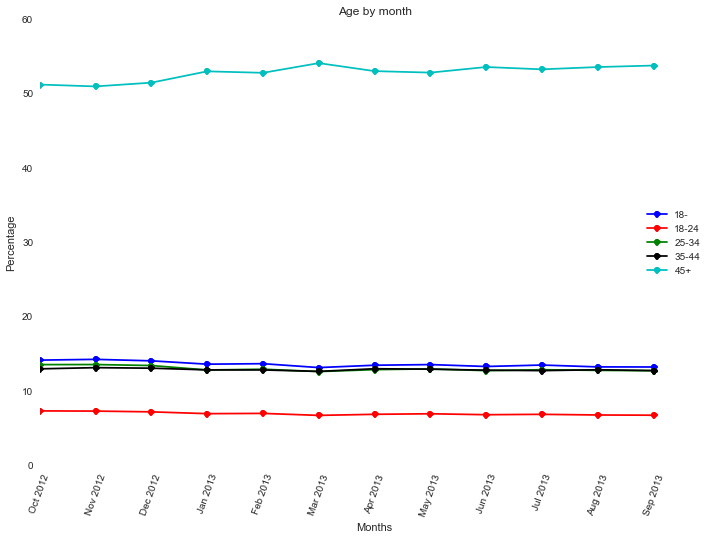

In [212]:
import matplotlib.pyplot as plt

## defines plot for the percentages of each bracket for each month


def plot_age(B1,B2,B3, B4, B5,t):
    
    plt.figure(figsize=(12,8))
    a, = plt.plot(B1,'bo-')
    b, = plt.plot(B2,'ro-')
    c, = plt.plot(B3,'go-')
    d, = plt.plot(B4,'ko-')
    e, = plt.plot(B5,'co-')
    plt.xlabel('Months')
    plt.ylabel('Percentage')
    plt.title('Age by month')
    plt.xticks(rotation=70) 
    if t == True:
        plt.xticks(range(12),['Oct 2012','Nov 2012','Dec 2012','Jan 2013','Feb 2013','Mar 2013','Apr 2013','May 2013','Jun 2013','Jul 2013','Aug 2013','Sep 2013'])
    else:
        plt.xticks(range(11),['Nov 2012','Dec 2012','Jan 2013','Feb 2013','Mar 2013','Apr 2013','May 2013','Jun 2013','Jul 2013','Aug 2013','Sep 2013'])
    plt.legend([a,b,c,d,e], ["18-",'18-24','25-34','35-44','45+'], loc=0)
plot_age(B1,B2,B3, B4, B5, True)

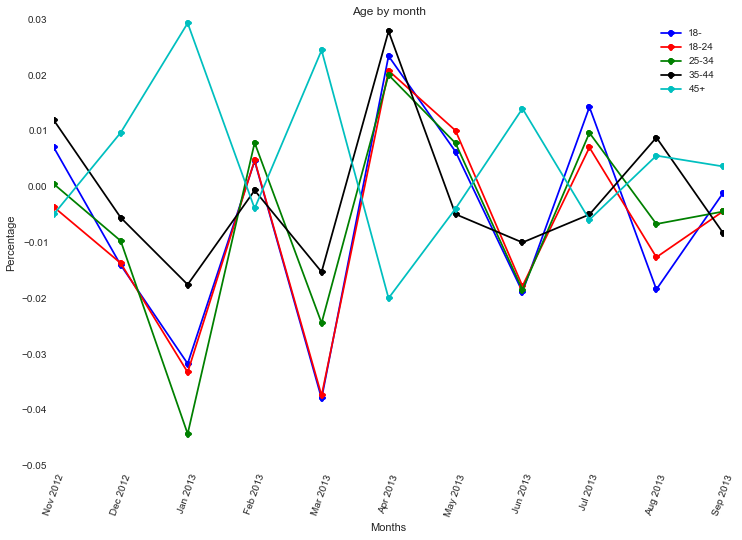

In [231]:
##  defining differences in the estimates for each bracket and plotting out

test1 = [(a-b)/b for a,b in zip(B1[1:],B1) ]
test2 = [(a-b)/b for a,b in zip(B2[1:],B2) ]
test3 = [(a-b)/b for a,b in zip(B3[1:],B3) ]
test4 = [(a-b)/b for a,b in zip(B4[1:],B4) ]
test5 = [(a-b)/b for a,b in zip(B5[1:],B5) ]

plot_age(test1,test2,test3,test4,test5,False)